# Clustering and differential expression analysis using scanpy

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import json
import os
import matplotlib.pyplot as plt
from scipy.stats import rankdata

In [ ]:
dataset_name = 'PBMC1' # modify this
data_in_path = './data/{}/filtered/10X/'.format(dataset_name)
data_out_path = './data/{}/scanpy/'.format(dataset_name)
antibody_path = '{}antibody/'.format(data_out_path)
top_number_of_markers = 500

## Data loading and preparation

Dataset loading

In [3]:
adata = sc.read_10x_mtx(
    data_in_path,
    var_names='gene_symbols',
    cache=False
)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 6966 × 13600
    var: 'gene_ids'

Studying feature variance

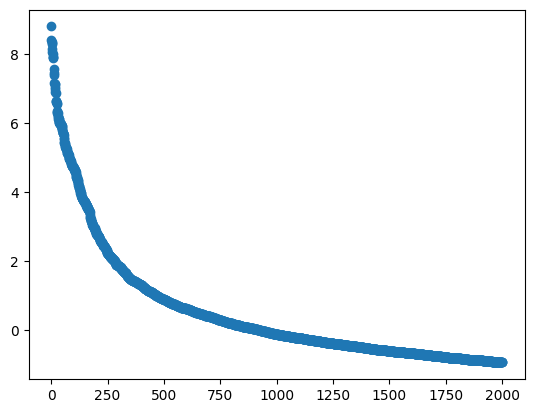

In [4]:
matrix = adata.X
matrix = matrix.todense()
neg_variances = np.sort(-np.var(matrix, axis=0))
sorted_log_variances = [np.log(-i) for i in neg_variances.T][:2000]
plt.scatter([i for i in range(len(sorted_log_variances))], sorted_log_variances)

Data normalization

In [5]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Feature selection

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


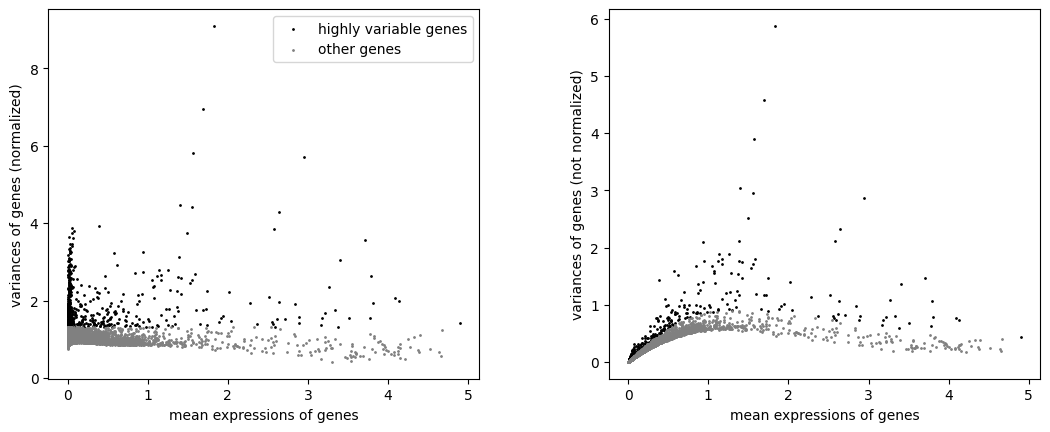

In [6]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=500, # chosen based on elbow plot above
    flavor='seurat_v3'
)
sc.pl.highly_variable_genes(adata)

Feature scaling

In [7]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10) # default=None, 10 in the tutorial on pbmc

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Plot pca explained variance ratio to choose number of components

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


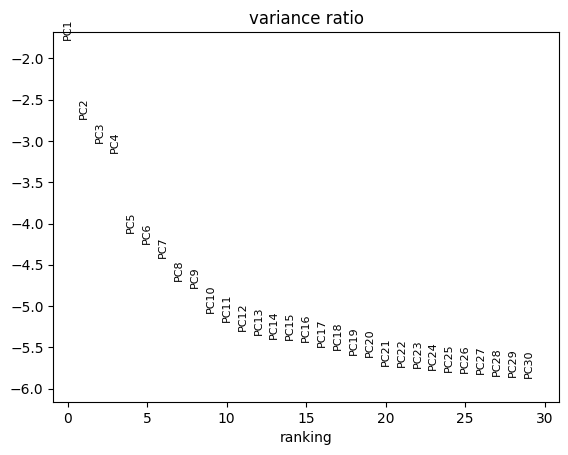

In [8]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=30, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

## Differential expression on antibody clusters

In [9]:
antibody_labels = pd.read_csv('./data/{}/antibody_annotation/antibody_labels_train.csv'.format(dataset_name))
antibody_labels.set_index('cell', inplace=True)
adata.obs = adata.obs.join(antibody_labels, how="left")
adata = adata[~adata.obs['cluster.ids'].isna()].copy()
adata.obs['cluster.ids'] = adata.obs['cluster.ids'].astype('category')
sc.tl.rank_genes_groups(adata, 'cluster.ids', method='wilcoxon') # default='t-test', wilcoxon suggested in the tutorial

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Save markers

In [10]:
markers_df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])
for cluster_id in adata.obs['cluster.ids'].cat.categories:
    cluster_id_str = str(cluster_id)
    indices = np.argsort(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id_str])
    genes = np.array(adata.uns['rank_genes_groups']['names'][cluster_id_str])[indices][:top_number_of_markers]
    ranks = rankdata(np.array(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id_str])[indices][:top_number_of_markers], method="ordinal")
    temp_df = pd.DataFrame(
        np.column_stack((genes, [cluster_id] * top_number_of_markers, ranks)),
        columns=['gene', 'cluster', 'rank']
    )
    markers_df = pd.concat([markers_df, temp_df], ignore_index=True)
markers_df['cluster'] = markers_df['cluster'].astype(str)
markers_df['rank'] = markers_df['rank'].astype(int)
markers_df.to_csv(f'{antibody_path}/markers.csv', index=False)

In [11]:
all_markers_df = pd.DataFrame(columns=['gene', 'cluster', 'p_val'])
for cluster_id in adata.obs['cluster.ids'].cat.categories:
    cluster_id_str = str(cluster_id)
    indices = np.argsort(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id_str])
    genes = np.array(adata.uns['rank_genes_groups']['names'][cluster_id_str])[indices]
    p_vals = np.array(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id_str])[indices]
    temp_df = pd.DataFrame({
        'gene': genes,
        'cluster': cluster_id,
        'p_val': p_vals
    })
    all_markers_df = pd.concat([all_markers_df, temp_df], ignore_index=True)
all_markers_df['cluster'] = all_markers_df['cluster'].astype(str)
all_markers_df.to_csv(f'{antibody_path}/markers_pval.csv', index=False)

/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_4247/4200585151.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_markers_df = pd.concat([all_markers_df, temp_df], ignore_index=True)
